In [1]:
import paddle
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sized


In [2]:
#下载数据
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data -O housing.data 

--2021-07-10 20:10:27--  https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49082 (48K) [application/x-httpd-php]
Saving to: ‘housing.data’

housing.data        100%[===================>]  47.93K   141KB/s    in 0.3s    

2021-07-10 20:10:28 (141 KB/s) - ‘housing.data’ saved [49082/49082]



In [3]:
 #从文件导入数据
datafile = './housing.data'
housing_data = np.fromfile(datafile, sep=' ')
feature_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE','DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
feature_num = len(feature_names)
# 将原始数据进行Reshape，变成[N, 14]这样的形状
housing_data = housing_data.reshape([housing_data.shape[0] // feature_num, feature_num])

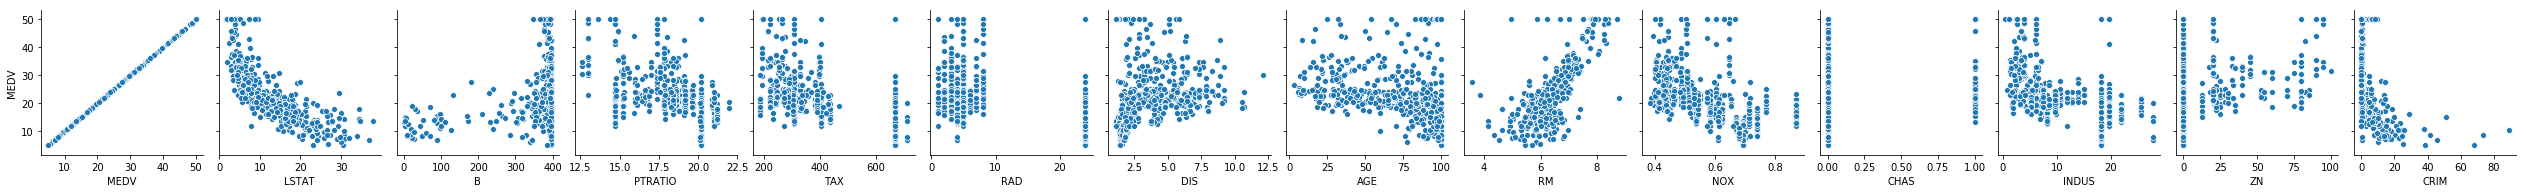

In [4]:
# 画图看特征间的关系,主要是变量两两之间的关系（线性或非线性，有无明显较为相关关系）
features_np = np.array([x[:13] for x in housing_data], np.float32)
labels_np = np.array([x[-1] for x in housing_data], np.float32)
# data_np = np.c_[features_np, labels_np]
df = pd.DataFrame(housing_data, columns=feature_names)
sns.pairplot(df.dropna(), y_vars=feature_names[-1], x_vars=feature_names[::-1], diag_kind='kde')
plt.show()


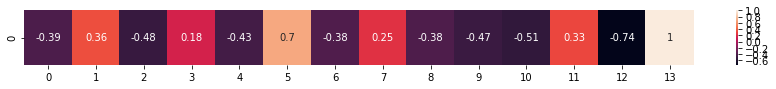

In [5]:
# 相关性分析
fig, ax = plt.subplots(figsize=(15, 1)) 
corr_data = df.corr().iloc[-1]
corr_data = np.asarray(corr_data).reshape(1, 14)
ax = sns.heatmap(corr_data, cbar=True, annot=True)
plt.show()


In [6]:
features_max = housing_data.max(axis=0)
features_min = housing_data.min(axis=0)
features_avg = housing_data.sum(axis=0) / housing_data.shape[0]


In [7]:
BATCH_SIZE = 20
def feature_norm(input):
    f_size = input.shape
    output_features = np.zeros(f_size, np.float32)
    for batch_id in range(f_size[0]):
        for index in range(13):
            output_features[batch_id][index] = (input[batch_id][index] - features_avg[index]) / (features_max[index] - features_min[index])
    return output_features 


In [8]:
# 只对属性进行归一化
housing_features = feature_norm(housing_data[:, :13])
# print(feature_trian.shape)
housing_data = np.c_[housing_features, housing_data[:, -1]].astype(np.float32)
# print(training_data[0])


In [9]:
# 将训练数据集和测试数据集按照8:2的比例分开
ratio = 0.8
offset = int(housing_data.shape[0] * ratio)
train_data = housing_data[:offset]
test_data = housing_data[offset:]

In [10]:
class Regressor(paddle.nn.Layer):
    def __init__(self):
        super(Regressor, self).__init__()
        self.fc1 = paddle.nn.Linear(13, 13,)
        self.re = paddle.nn.ReLU()
        self.fc2 = paddle.nn.Linear(13, 1,)

    def forward(self, inputs):
        pred = self.fc1(inputs)
        pred = self.re(inputs)
        pred = self.fc2(inputs)
        return pred

In [17]:
train_nums = []
train_costs = []

def draw_train_process(iters, train_costs):
    plt.title("training cost", fontsize=24)
    plt.xlabel("iter", fontsize=14)
    plt.ylabel("cost", fontsize=14)
    plt.plot(iters, train_costs, color='red', label='training cost')
    plt.show()

In [12]:
import paddle.nn.functional as F 
y_preds = []
labels_list = []

def train(model):
    print('start training ... ')
    # 开启模型训练模式
    model.train()
    EPOCH_NUM = 500
    train_num = 0
    optimizer = paddle.optimizer.SGD(learning_rate=0.001, parameters=model.parameters())
    for epoch_id in range(EPOCH_NUM):
        # 在每轮迭代开始之前，将训练数据的顺序随机的打乱
        np.random.shuffle(train_data)
        # 将训练数据进行拆分，每个batch包含20条数据
        mini_batches = [train_data[k: k+BATCH_SIZE] for k in range(0, len(train_data), BATCH_SIZE)]
        for batch_id, data in enumerate(mini_batches):
            features_np = np.array(data[:, :13], np.float32)
            labels_np = np.array(data[:, -1:], np.float32)
            features = paddle.to_tensor(features_np)
            labels = paddle.to_tensor(labels_np)
            # 前向计算
            y_pred = model(features)
            cost = F.mse_loss(y_pred, label=labels)
            train_cost = cost.numpy()[0]
            # 反向传播
            cost.backward()
            # 最小化loss，更新参数
            optimizer.step()
            # 清除梯度
            optimizer.clear_grad()
            
            if batch_id%30 == 0 and epoch_id%50 == 0:
                print("Pass:%d,Cost:%0.5f"%(epoch_id, train_cost))

            train_num = train_num + BATCH_SIZE
            train_nums.append(train_num)
            train_costs.append(train_cost)
        
model = Regressor()
train(model)

start training ... 
Pass:0,Cost:589.45312
Pass:50,Cost:44.64929
Pass:100,Cost:64.95304
Pass:150,Cost:102.51646
Pass:200,Cost:44.85944
Pass:250,Cost:29.20915
Pass:300,Cost:55.89227
Pass:350,Cost:51.51464
Pass:400,Cost:23.76886
Pass:450,Cost:17.52610


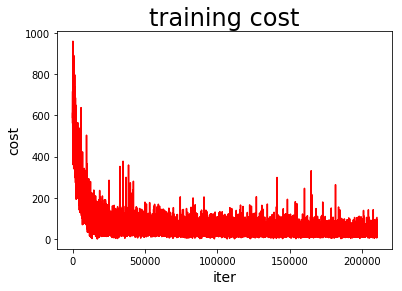

In [13]:
matplotlib.use('TkAgg')
%matplotlib inline
draw_train_process(train_nums, train_costs)

In [14]:
# 获取预测数据
INFER_BATCH_SIZE = 100

infer_features_np = np.array([data[:13] for data in test_data]).astype("float32")
infer_labels_np = np.array([data[-1] for data in test_data]).astype("float32")

infer_features = paddle.to_tensor(infer_features_np)
infer_labels = paddle.to_tensor(infer_labels_np)
fetch_list = model(infer_features)

sum_cost = 0
for i in range(INFER_BATCH_SIZE):
    infer_result = fetch_list[i][0]
    ground_truth = infer_labels[i]
    if i % 10 == 0:
        print("No.%d: infer result is %.2f,ground truth is %.2f" % (i, infer_result, ground_truth))
    cost = paddle.pow(infer_result - ground_truth, 2)
    sum_cost += cost
mean_loss = sum_cost / INFER_BATCH_SIZE
print("Mean loss is:", mean_loss.numpy())

No.0: infer result is 12.11,ground truth is 8.50
No.10: infer result is 5.47,ground truth is 7.00
No.20: infer result is 14.66,ground truth is 11.70
No.30: infer result is 16.35,ground truth is 11.70
No.40: infer result is 13.47,ground truth is 10.80
No.50: infer result is 15.77,ground truth is 14.90
No.60: infer result is 18.71,ground truth is 21.40
No.70: infer result is 15.41,ground truth is 13.80
No.80: infer result is 18.09,ground truth is 20.60
No.90: infer result is 21.41,ground truth is 24.50
Mean loss is: [12.510718]


In [15]:
def plot_pred_ground(pred, ground):
    plt.figure()   
    plt.title("Predication v.s. Ground truth", fontsize=24)
    plt.xlabel("ground truth price(unit:$1000)", fontsize=14)
    plt.ylabel("predict price", fontsize=14)
    plt.scatter(ground, pred, alpha=0.5)  #  scatter:散点图,alpha:"透明度"
    plt.plot(ground, ground, c='red')
    plt.show()

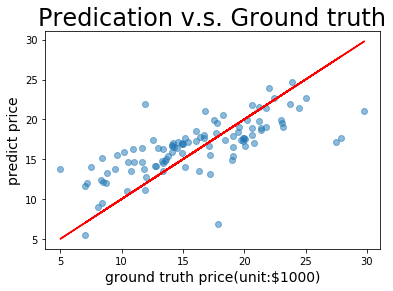

In [16]:
plot_pred_ground(fetch_list, infer_labels_np)